# Classification Trees Notebook

In this notebook we illustrate the use of classification trees. We show how to build the tree and then obtain the rules corresponding to the tree. We also show how to avoid growing trees that are too big and over-fit the training data. This is done by a procedure called pre-pruning. Currently, post-pruning is not implemented in scikit-learn. An optimized version of the CART algorithm is used in scikit-learn.

First we import the required packages.

In [10]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import graphviz 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

### Loading the Data

We load the data from a CSV file using pandas. The dataset considered is 'Wisconsin Diagnostic Breast Cancer' from the UCI repository. We ignore the first attribute in this dataset, which corresponds to the ID of each sample. The task of interest is to predict whether or not a cell corresponds to a malignant tumor. In this dataset all attributes take real values. These include area, smoothness, perimeter, etc.

In [11]:
data = pd.read_csv('wdbc.csv')
X = data.values[ :, 2:].astype(float)
y = (data.values[ :, 1 ] == 'B').astype(int)

### Data Partition into Train and Test


We randomly split the data into train and test partitions. We use 70% of the data for training and 30% for testing. 


In [12]:
X_train, X_test, y_train, y_test = train_test_split( \
    X, y, test_size=0.3, random_state=1)

### Data Standardization


We avoid the data standardization (normalizing to have zero mean and unit variance in each attribute) because this step is not needed by classification trees. Potential pre-procesing steps that may improve the results with classification trees include finding the principal components of the data.

## Choosing good vales for the pre-pruning parameters

To avoid growing trees that are too big, we will specify values for the parameter "max_depth". Therefore, a node will not split if the maximum depth of the tree has been reached. In that case, the node will become a leaf. This will result is trees of smaller size.

### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the inner cross validation procedure. If required, in this pipeline we may also consider extra data transformations such as additional pre-procesing steps for each partition of the data. We omit this step here.

In [13]:
pipeline = Pipeline([ ('tree', DecisionTreeClassifier()) ])

### Indicating Potential Values for the Hyperparameters

We specify values for the hyperparameters of the classifier. In this case, the max_depth of the tree. We also set the random state of the tree to a value to avoid having different trees (if two attributes lead to the same decrease of impurity, the best attribute is chosen at random).

In [14]:
max_depth_values = np.arange(1, 10,1).astype(int)
param_grid = { 'tree__max_depth': max_depth_values, 'tree__random_state' : [1] }

### Evaluating the Performance for each Value of the Hyperparameters

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv.

In [15]:
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
    scoring=make_scorer(accuracy_score))
result = gridcv.fit(X_train, y_train)

### Obtaining the Results

We get the mean accuracy and the corresponding standard deviation across data splits.

In [16]:
accuracies = gridcv.cv_results_['mean_test_score']
std_accuracies = gridcv.cv_results_['std_test_score']

We also obtain the accuracy on the test set for comparison purposes.

In [17]:
test_accuracies = np.ones(len(max_depth_values))

for i in range(len(max_depth_values)):
    tree = DecisionTreeClassifier(max_depth = max_depth_values[ i ], random_state = 1)
    tree.fit(X_train, y_train)
    test_accuracies[ i ] = accuracy_score(tree.predict(X_test), y_test)

### Plotting the Results


For a better visualization of the average results, we plot them, showing also the corresponding standard deviation estimate.

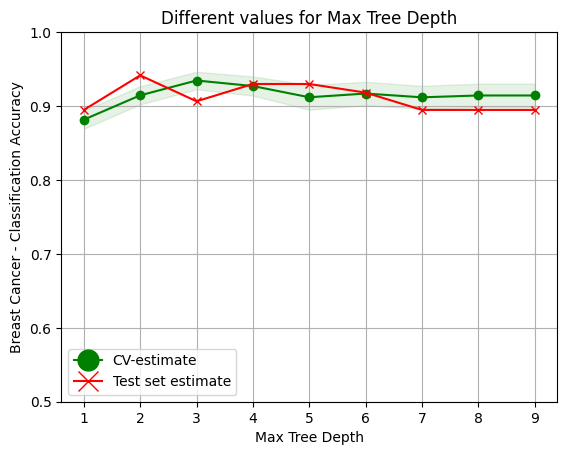

In [18]:
plt.figure()
line1, = plt.plot(max_depth_values, accuracies, 'o-', color="g")
line2, = plt.plot(max_depth_values, test_accuracies, 'x-', color="r")
plt.fill_between(max_depth_values, accuracies - std_accuracies / np.sqrt(10), \
    accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
plt.grid()
plt.title("Different values for Max Tree Depth")
plt.xlabel('Max Tree Depth')
plt.xticks(np.array(max_depth_values))
plt.ylabel('Breast Cancer - Classification Accuracy')
plt.ylim((0.5, 1.0))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                          markersize=15, label='CV-estimate'), \
                mlines.Line2D([], [], color='r', marker='x', \
                          markersize=15, label='Test set estimate')]
plt.legend(handles=legend_handles, loc = 3)
plt.show()

In [19]:
print('The best parameter value according to the cv-estimate is: %f' \
      % max_depth_values[ np.argmax(accuracies) ])
print('The best parameter cv accuracy estimate is: %f' \
      % accuracies[ np.argmax(accuracies) ])

The best parameter value according to the cv-estimate is: 3.000000
The best parameter cv accuracy estimate is: 0.934551


## Fitting the Final Model and Estimating Its Performance

For this step, we use the whole training data available and the best observed parameter value. 

We train the classifier.

In [20]:
tree = DecisionTreeClassifier(max_depth = max_depth_values[ np.argmax(accuracies) ], \
       random_state = 1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

### Evaluating the Performance on the Test Set

We compute the confusion matrix on the test set.

In [21]:
y_pred = tree.predict(X_test)

In [22]:
conf = confusion_matrix(y_test, y_pred)

In [23]:
# The matrix conf contains:
# TN | FN
# FP | TP

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[ 46   8]
 [  8 109]]
Predicion accuracy is: 0.906433
True postive rate is: 0.931624
True negative rate is: 0.851852



## Drawing the Resulting Tree

We use the package and binaries of graphviz to visualize the tree.

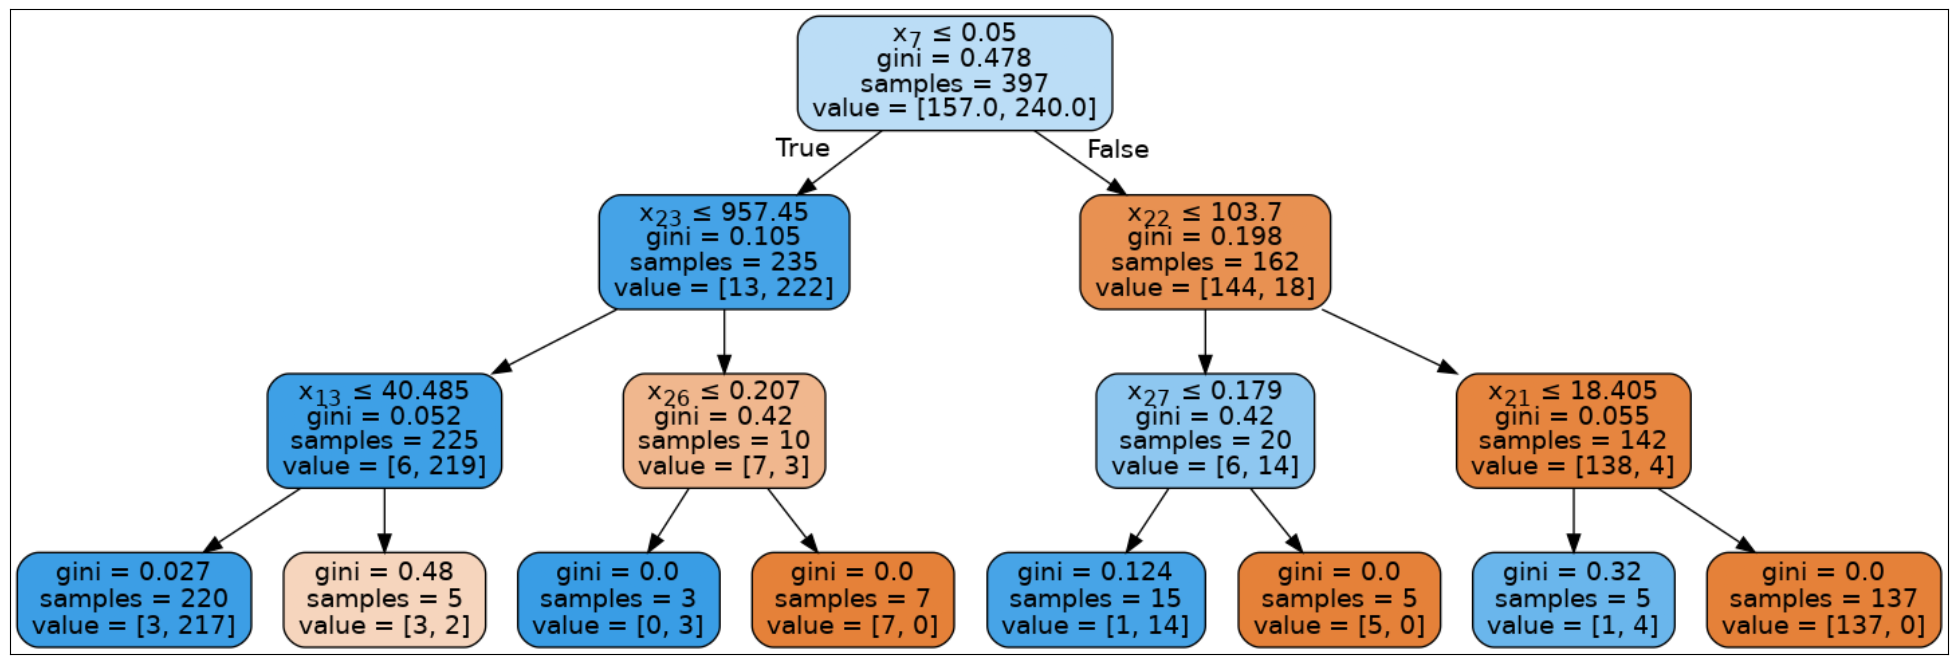

In [24]:
# We save the tree into a PNG image

dot_data = export_graphviz(tree, out_file=None, filled=True, \
                           rounded=True, special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('/tmp/tree.png')

# We now plot the PNG image

img=mpimg.imread('/tmp/tree.png')
plt.figure(figsize = (25,25))
fig = plt.imshow(img, interpolation='bilinear')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

## Pseudo-code Generation

We use the decision tree learned, to obtain the corresponding pseudo-code. This is based on a post from <a id="section_ID" href = "http://stackoverflow.com/a/30104792">Stack Overflow</a>. For this, we first, write a function that will carry out this task. The code is found below.

In [25]:
def get_code(tree, feature_names, target_names,
             spacer_base="    "):
    """Produce psuedo-code for decision tree.

    ArgsLanzarListadoPubGuiaDocAs
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "}\n" + spacer +"else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print(spacer + "}")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( " + str(target_count) + " examples )")

    recurse(left, right, threshold, features, 0, 0)

We now show the resulting pseudo-code. For this, we specify the feature names and the class names in the call to "get_code".

In [26]:
get_code(tree, [ 'X' + str(i)  for i in range(X.shape[ 1 ]) ], ['Malignant', 'Benign'])

if ( X7 <= 0.04988499917089939 ) {
    if ( X23 <= 957.4500122070312 ) {
        if ( X13 <= 40.48500061035156 ) {
            return Malignant ( 0 examples )
            return Benign ( 0 examples )
        }
        else {
            return Malignant ( 0 examples )
            return Benign ( 0 examples )
        }
    }
    else {
        if ( X26 <= 0.20709999650716782 ) {
            return Benign ( 1 examples )
        }
        else {
            return Malignant ( 1 examples )
        }
    }
}
else {
    if ( X22 <= 103.70000076293945 ) {
        if ( X27 <= 0.17864999920129776 ) {
            return Malignant ( 0 examples )
            return Benign ( 0 examples )
        }
        else {
            return Malignant ( 1 examples )
        }
    }
    else {
        if ( X21 <= 18.40499973297119 ) {
            return Malignant ( 0 examples )
            return Benign ( 0 examples )
        }
        else {
            return Malignant ( 1 examples )
        }
    }
}


## Classification Frontier Visualization

We show how the decision boundaries of the classifier look like for different values of the hyper-parameters. For simplicity, we only consider the first two attributes of the previous problem. We use all the available data.

In [27]:
X = X[:, [0, 1]]

We plot the data we are going to train the classifier on.

In [28]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

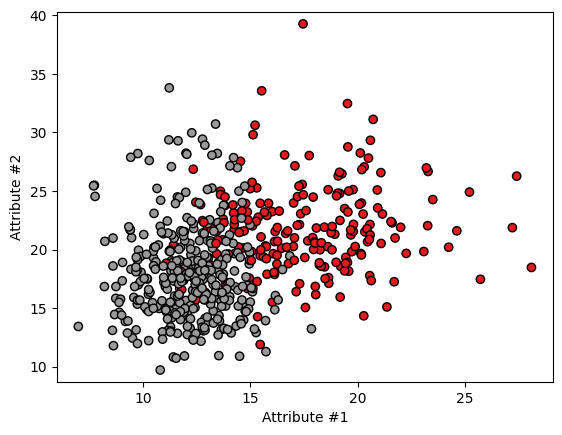

In [29]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We train the classifier for different values of the min_impurity_decrase parameter [0, .005, .01 ] and look at the results. 

In [30]:
max_depths = [ 1, 3, 10 ]
trees = [ DecisionTreeClassifier(max_depth=x, random_state = 1) for x in max_depths ]

for i in range(len(trees)):
    trees[ i ].fit(X, y)

We plot the resulting decision boundaries. We plot in the second row the corresponding tree.

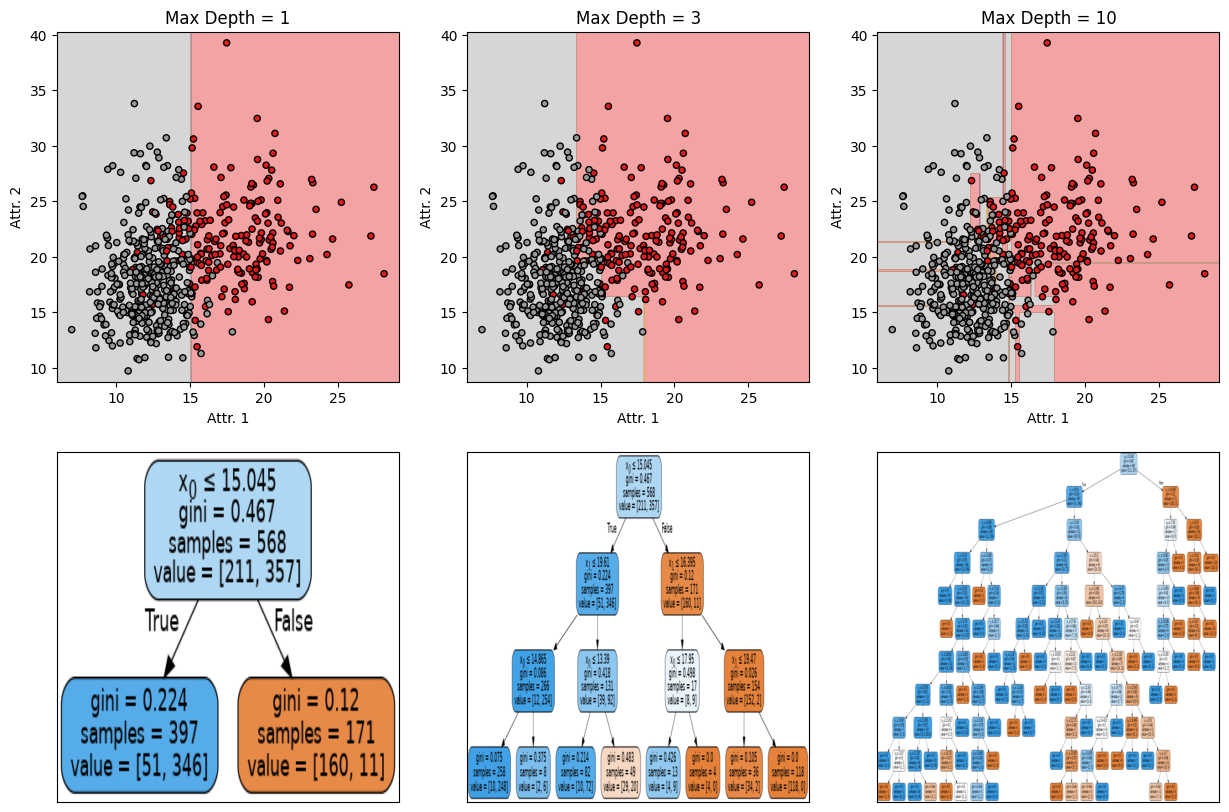

In [31]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.025),
                     np.arange(y_min, y_max, 0.025))

f, axarr = plt.subplots(2, 3, figsize=(15, 10))

for i in range(len(trees)):

    Z = trees[ i ].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[0,i].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
    axarr[0,i].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k',\
        cmap=plt.cm.Set1)
    axarr[0,i].set_title('Max Depth = ' + str(max_depths[ i ]))
    axarr[0,i].set_xlabel('Attr. 1')
    axarr[0,i].set_ylabel('Attr. 2')
    
     # We save the tree into a PNG image

    dot_data = export_graphviz(trees[ i ], out_file=None, filled=True, \
                           rounded=True, special_characters=True) 
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png('/tmp/tree.png')


    # We now plot the PNG image

    img=mpimg.imread('/tmp/tree.png')
    fig = axarr[ 1, i ].imshow(img, interpolation='bilinear', aspect = 'auto')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
            

plt.show()

We observe that the decision boundaries obtained by the classification tree are obtained by splits that are perpendicular to the axis. Furhtermore, it seems that a fully grown tree over-fits the training data, as there are many regions in which different class labels are predicted. A tree that is too small under-fits the data.